<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MODELING" data-toc-modified-id="MODELING-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MODELING</a></span><ul class="toc-item"><li><span><a href="#Test-Train-Split" data-toc-modified-id="Test-Train-Split-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test-Train Split</a></span><ul class="toc-item"><li><span><a href="#Checking-Trian-Test-Composition" data-toc-modified-id="Checking-Trian-Test-Composition-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Checking Trian-Test Composition</a></span></li><li><span><a href="#Splitting-to-Input-X-and-Output-y" data-toc-modified-id="Splitting-to-Input-X-and-Output-y-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Splitting to Input X and Output y</a></span></li></ul></li><li><span><a href="#Relevant-Function-Definitions" data-toc-modified-id="Relevant-Function-Definitions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relevant Function Definitions</a></span><ul class="toc-item"><li><span><a href="#Scoring-Functions" data-toc-modified-id="Scoring-Functions-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Scoring Functions</a></span></li><li><span><a href="#Get-Top-Features" data-toc-modified-id="Get-Top-Features-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Get Top Features</a></span></li><li><span><a href="#Multi-label-Predict" data-toc-modified-id="Multi-label-Predict-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Multi-label Predict</a></span></li><li><span><a href="#Analyze-a-Single-Movie-Plot" data-toc-modified-id="Analyze-a-Single-Movie-Plot-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Analyze a Single Movie Plot</a></span></li></ul></li></ul></li></ul></div>

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow_hub as hub


import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)


C:\Users\smaiya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\smaiya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
W0306 23:35:36.771159  6716 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smaiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smaiya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# MODELING

In [78]:
# Read the data
preprocessed_data = False
if os.path.exists('../Data/preprocessed/movies_genres_preprocessed.csv'):
    mydata = pd.read_csv('../Data/preprocessed/movies_genres_preprocessed.csv')
    preprocessed_data = True
else:
    mydata = pd.read_csv('../Data/movies_genres.csv', delimiter='\t')
    
category_columns = mydata.columns.drop(['title', 'plot', 'plot_lang'])
for col in category_columns:
    mydata[col] = mydata[col].astype('category')

## Test-Train Split
Now let us first split the provided data into a train and test sets. This is a multi-label data set with highly imbalanced labels (Adult having just 61 samples and Drama with >45000 samples). In the below function `multi_label_train_test_split`, we split the provided data set ensuring that both the data sets have a minimum fraction of every labels. The minimum fraction is provided as an input parameter. We loop through each category and include `min_test_size` fraction of that category into the test data set. Clearly at the end of the loop, the number of occurence of each category will be greater than the `min_test_size` fraction since most movies that are being included into the test set as a particular genre also are categorized with other genres. 

We can further optimize the below function to ensure that more even distribution of movies into train and test data set; however, that is not really the aim of this project. Hence we will just stick to this simplified version. 

In [79]:
def multi_label_train_test_split(data, labels, min_test_size=0.15, shuffle=True, random_state=29):
    data_size = data.shape[0]
    
    # data_test_idx holds the test indices corresponding to the original data DataFrame
    data_test_idx = np.array([False]*data_size)
    
    n_folds = math.floor(1/min_test_size)
    data_train, data_test = pd.DataFrame(), pd.DataFrame()
    for col in labels:
        # Extracting the current genre plots
        data_curr_genre = data[data[col]==1]
        
        curr_genre_size = data_curr_genre.shape[0]
        curr_test_size = math.ceil(curr_genre_size*min_test_size)
        
        # Using KFold to get the test_idx for the current genre
        curr_genre_test_idx = np.array([False]*curr_genre_size)
        kf = KFold(curr_genre_size, n_folds=n_folds, shuffle=shuffle, random_state=random_state)
        # Using the first fold values for the test indices for the current genre
        curr_genre_test_idx[kf.idxs[0:curr_test_size]]=True
        
        # Mapping the test indices in the data_curr_genre back to the original data DataFrame
        data_test_idx[data_curr_genre[curr_genre_test_idx].index]=True
    
    data_test = data[data_test_idx]
    data_train = data[~data_test_idx]
    return data_train, data_test

**Preprocessing the training and testing data sets separately**

In [80]:
if os.path.exists('./../Data/preprocessed/movies_genres_train_preprocessed.csv') and os.path.exists('./../Data/preprocessed/movies_genres_test_preprocessed.csv'):
    mydata_train = pd.read_csv('./../Data/preprocessed/movies_genres_train_preprocessed.csv')
    mydata_test = pd.read_csv('./../Data/preprocessed/movies_genres_test_preprocessed.csv')
else:
    mydata_raw = pd.read_csv('./../Data/movies_genres.csv', delimiter='\t')
    min_test_size = 0.1
    mydata_train, mydata_test = multi_label_train_test_split(mydata_raw, category_columns, min_test_size=min_test_size)
    
    mydata_train['plot'] = mydata_train['plot'].apply(text_preprocess)
    mydata_train.to_csv('./../Data/preprocessed/movies_genres_train_preprocessed.csv', index=False)
    
    mydata_test['plot'] = mydata_test['plot'].apply(text_preprocess)
    mydata_test.to_csv('./../Data/preprocessed/movies_genres_test_preprocessed.csv', index=False)

### Checking Trian-Test Composition

Let us check the composition of train and test data set to ensure each label occur with reasonable fraction in both these data sets. The test dataset considered has ~0.2 of the entire dataset. 

In [81]:
print('Fraction of data in the Training Data Set: {0:.3f}'.format(mydata_test.shape[0]/mydata.shape[0]))

Fraction of data in the Training Data Set: 0.195


Looking at each of the datasets to see how many movies of each genres are present

In [82]:
sum_genre = mydata[category_columns].sum()
sum_genre_train = mydata_train[category_columns].sum()
sum_genre_test = mydata_test[category_columns].sum()
df_movies_per_genre_1 = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre_train/sum_genre, 'Data Set': 'Train'})
df_movies_per_genre_2 = pd.DataFrame({'Genre':category_columns, 'Total': sum_genre_test/sum_genre, 'Data Set': 'Test'})
df_movies_per_genre = pd.concat([df_movies_per_genre_1, df_movies_per_genre_2])

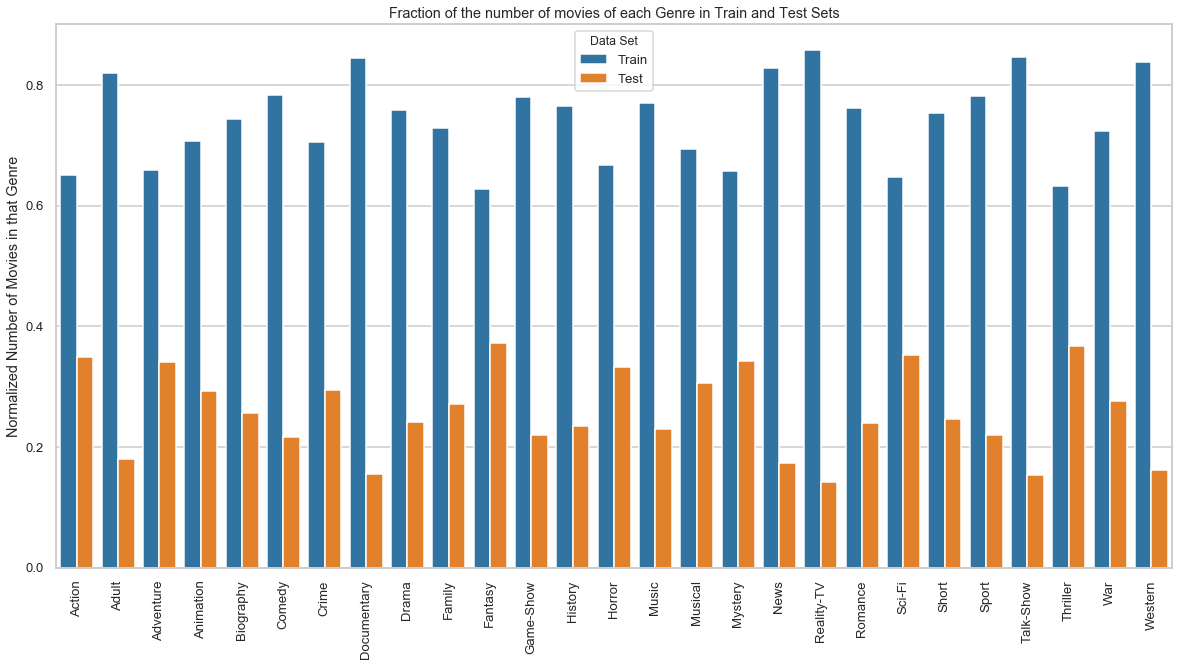

In [83]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', hue='Data Set', axes=ax)
ax.set(ylabel='Normalized Number of Movies in that Genre', xlabel='')
ax.set(title='Fraction of the number of movies of each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()

**Observations**  
* For every category, we have at least 60% of the samples in the training data set and at least 15% of the samples in the test data set which seems good for our purpose

### Splitting to Input X and Output y

In [84]:
train_X, train_y = mydata_train['plot'], mydata_train.drop(['title', 'plot', 'plot_lang'], axis=1)
test_X, test_y = mydata_test['plot'], mydata_test.drop(['title', 'plot', 'plot_lang'], axis=1)

## Relevant Function Definitions

### Scoring Functions

In [85]:
def accuracy(y_actual, y_predict):
    result = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Support'])
    tp, fp, fn, total = 0, 0, 0, 0
    if not isinstance(y_predict, pd.DataFrame):
        y_predict = pd.DataFrame(y_predict, columns=y_actual.columns)
    for col in y_actual.columns:
        support = y_actual[col].sum()
        tp = ((y_actual[col]==1) & (y_predict[col]==1)).sum()
        fp = ((y_actual[col]==0) & (y_predict[col]==1)).sum()
        fn = ((y_actual[col]==1) & (y_predict[col]==0)).sum()
        
        precision = 0 if (tp+fp==0) else tp/(tp+fp)
        recall = 0 if (tp+fn==0) else tp/(tp+fn)
        f1_score = 0 if (precision==0 and recall==0) else 2*precision*recall/(precision+recall)
        
        result.loc[col] = [precision, recall, f1_score, support]
    
    avg_precision = (result['Precision']*result['Support']).sum()/result['Support'].sum()
    avg_recall = (result['Recall']*result['Support']).sum()/result['Support'].sum()
    avg_f1_score = (result['F1-Score']*result['Support']).sum()/result['Support'].sum()
    result.loc['Avg/Total'] = [avg_precision, avg_recall, avg_f1_score, result['Support'].sum()]
    
    return round(result, 2)

In [99]:
def overall_f1_score_v1(y_actual, y_predict):
    tp, fp, fn = 0, 0, 0
    for idx, col in enumerate(category_columns):
        tp+=((y_actual[col]==1) & (y_predict[:,idx]==1)).sum()
        fp+=((y_actual[col]==0) & (y_predict[:,idx]==1)).sum()
        fn+=((y_actual[col]==1) & (y_predict[:,idx]==0)).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

overall_f1_score_v1_cv = make_scorer(overall_f1_score_v1, greater_is_better=True)

In [96]:
def overall_f1_score_v2(y_actual, y_predict):
    # cluster_center must contain the label to genre combination mapping! 
    y_actual_matrix = np.empty((y_actual.shape[0], len(category_columns)))
    y_predict_matrix = np.empty((y_actual.shape[0], len(category_columns)))
    
    num_class = cluster_center.shape[0]
    for idx in range(num_class):
        if idx in y_predict:
            y_predict_matrix[y_predict==idx,:] = cluster_center.loc[idx,:].values
        if idx in y_actual:
            y_actual_matrix[y_actual==idx,:] = cluster_center.loc[idx,:].values 
    
    tp, fp, fn = 0, 0, 0
    for idx in range(len(category_columns)):
        tp+=((y_actual_matrix[:,idx]==1) & (y_predict_matrix[:,idx]==1)).sum()
        fp+=((y_actual_matrix[:,idx]==0) & (y_predict_matrix[:,idx]==1)).sum()
        fn+=((y_actual_matrix[:,idx]==1) & (y_predict_matrix[:,idx]==0)).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return f1_score

overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True)

### Get Top Features 

In [87]:
def get_features_tfidf(pipeline, labels, num_features=10, prob_only=False):
    tfidf_vectorizer = pipeline.get_params()['tfidf']
    clf = pipeline.get_params()['clf']
    words = np.array(tfidf_vectorizer.get_feature_names())
    x=sparse.identity(words.shape[0])
    if num_features<=0:
        num_features = words.shape[0]
    probs = clf.predict_proba(x)
    feature_id = ['P{0}'.format(i) for i in range(1, num_features+1)]
    df_good_features = pd.DataFrame(columns=feature_id)
    for col in labels:
        ind = np.argsort(probs[:,list(category_columns).index(col)])
        
        good_prob = probs[ind[-num_features:], list(category_columns).index(col)]
        if prob_only:
            good_list = good_prob
        else:
            good_words = words[ind[-num_features:]]
            good_list = ['{0} (p={1:.2f})'.format(w, p) for w, p in zip(good_words, good_prob)]
        
        df_good_features.loc[col,:] = good_list[::-1]
    return df_good_features

### Multi-label Predict

In [88]:
def get_prob_thresh(thresh_sel=1, thresh_offset=0):
    prob_thresh=[]
    if thresh_sel==1:
        prob_thresh = [0.5] * len(category_columns)
    elif thresh_sel==2:
        sum_genre = mydata[category_columns].sum()
        prob_thresh = (sum_genre/mydata.shape[0]+thresh_offset).clip(upper=0.5)
    return prob_thresh

In [89]:
def multi_label_predict(clf, X_test, thresh_sel=1, thresh_offset=0):
    prob_thresh = get_prob_thresh(thresh_sel, thresh_offset)
    y_pred = pd.DataFrame(columns=category_columns)
    
    prob = clf.predict_proba(X_test)
    for idx, col in enumerate(y_pred):
        y_pred[col] = prob[:,idx]>prob_thresh[idx]
    prob = pd.DataFrame(prob, columns=category_columns)
    return prob, y_pred

In [90]:
def multi_class_predict(clf, X_test, class_to_genre_map):
    y_pred = pd.DataFrame(index=test_X.index, columns=category_columns)
    
    num_class = class_to_genre_map.shape[0]
    y_class = clf.predict(X_test)
    for idx in range(num_class):
        if idx in y_class:
            y_pred.loc[y_class==idx,:] = class_to_genre_map.loc[idx,:].values
    return y_pred

### Analyze a Single Movie Plot

In [1]:
def analyze_plot_genre(pipeline, plot, genre):
    plot = pd.Series(plot.split())
    
    tfidf_vectorizer = pipeline.get_params()['tfidf']
    clf = pipeline.get_params()['clf']
    words = np.array(tfidf_vectorizer.get_feature_names())
    x=sparse.identity(words.shape[0])
    
    probs = pipeline.predict_proba(plot)
    
    result = pd.DataFrame(columns=['word']+genre)
    result['word'] = plot
    for col in genre:
        result[col] = probs[:, list(category_columns).index(col)]
    
    return result